In [ ]:
import gzip
import pickle
import numpy as np
from pathlib import Path
import torch
from  acr_bb import Observation, ACRBBenv, DefaultBranchingPolicy, RandomPolicy, LinearObservation
from fcn_policy import FCNDataset, FCNBranchingPolicy, FCNNodeSelectionPolicy 

MAX_SAMPLES = 100000

N = 8 # antennas
M = 4 # users
expert_prob = 0.5

def instance_generator(M, N):
    while 1:
        yield np.random.randn(2,N,M)

# instances = np.random.randn(MAX_SAMPLES, 2, N, M)
instances = instance_generator(M,N)

env = ACRBBenv()

expert_policy = DefaultBranchingPolicy()
random_policy = RandomPolicy()

episode_counter, sample_counter = 0, 0
Path('positive_node_samples/').mkdir(exist_ok=True)
Path('negative_node_samples/').mkdir(exist_ok=True)

# We will solve problems (run episodes) until we have saved enough samples
max_samples_reached = False

while not max_samples_reached:
    episode_counter += 1
    
    observation_list = []
    node_indices = []
    observation, action_set, reward, done, _ = env.reset(next(instances))
    node_indices.append(env.active_node.node_index)
    observation_list.append(observation)
    while not done and reward > -5:
        if np.random.rand(1) > expert_prob:
            action_id = expert_policy.select_variable(observation, action_set)
        else:
            action_id = random_policy.select_variable(observation, action_set)

        observation, action_set, reward, done, _ = env.step(action_id)
    
    for node in env.all_nodes:
        if node.optimal:
            for i in range(len(node_indices)):
                if node_indices[i] == node.node_index:
                    data = [observation_list[i], True]
                    break
        else:
            for i in range(len(node_indices)):
                if node_indices[i] == node.node_index:
                    data = [observation_list[i], False]
                    break
            
        if not max_samples_reached:
            sample_counter += 1
            
            if node.optimal:
                filename = f'positive_node_samples/sample_{sample_counter}.pkl'
            else:
                filename = f'negative_node_samples/sample_{sample_counter}.pkl'
                
            with gzip.open(filename, 'wb') as f:
                pickle.dump(data, f)
            # If we collected enough samples, we finish the current episode but stop saving samples
            if sample_counter >= MAX_SAMPLES:
                max_samples_reached = True
                break;
    print(f"Episode {episode_counter}, {sample_counter} samples collected so far")


# Train FCN model for node Selection classifier

In [1]:
import torch
import torch.nn.functional as F
import torch_geometric
from fcn_policy import FCNNodeDataset, FCNNodeFakeDataset, FCNBranchingPolicy, FCNNodeSelectionPolicy, FCNNodeSelectionLinearPolicy
from tqdm import tqdm
from pathlib import Path
import torch.nn as nn
import matplotlib.pyplot as plt
import random
import math 
from torch.utils.data import DataLoader

LEARNING_RATE = 0.001
NB_EPOCHS = 150
PATIENCE = 10
EARLY_STOPPING = 20
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sig = nn.Sigmoid()

def process(policy, data_loader, optimizer=None):
    """
    This function will process a whole epoch of training or validation, depending on whether an optimizer is provided.
    """
    mean_loss = 0
    mean_acc = 0

    n_samples_processed = 0
    targets_list = torch.Tensor([]).to(DEVICE)
    preds_list = torch.Tensor([]).to(DEVICE)
    with torch.set_grad_enabled(optimizer is not None):
        for batch_data in tqdm(data_loader):
            batch, target = batch_data
#             print(batch[0], batch[1])
#             print(target.sum())
            batch = batch.to(DEVICE)
            target = target.squeeze().to(DEVICE)*1
            
            out = policy(batch).squeeze()

            bce = nn.BCELoss()
            
            loss = bce(out, target.to(torch.float))
            
            if optimizer is not None:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            predicted_bestindex = (out>0.5)*1
            accuracy = sum(predicted_bestindex.reshape(-1) == target)
            
            targets_list = torch.cat((targets_list, target))
            preds_list = torch.cat((preds_list, predicted_bestindex))
            
            mean_loss += loss.item() * batch.shape[0]
            mean_acc += float(accuracy)
            n_samples_processed += batch.shape[0]

    stacked = torch.stack((targets_list, preds_list), dim=1).to(torch.int)
    cmt = torch.zeros(2,2,dtype=torch.int64)
    for p in stacked:
        tl, pl = p.tolist()
        cmt[tl, pl] = cmt[tl, pl] + 1
    print(cmt)
    precision = cmt[1,1]/(cmt[0,1]+cmt[1,1])
    recall = cmt[1,1]/(cmt[1,0]+cmt[1,1])
    mean_acc = 2* (precision*recall)/(precision+recall)
    print(n_samples_processed)
    mean_loss /= n_samples_processed
#     mean_acc /= n_samples_processed
    return mean_loss, mean_acc


def pad_tensor(input_, pad_sizes, pad_value=-1e8):
    """
    This utility function splits a tensor and pads each split to make them all the same size, then stacks them.
    """
    max_pad_size = pad_sizes.max()
    output = input_.split(pad_sizes.cpu().numpy().tolist())
    output = torch.stack([F.pad(slice_, (0, max_pad_size-slice_.size(0)), 'constant', pad_value)
                          for slice_ in output], dim=0)
    return output



positive_sample_files = [str(path) for path in Path('data/2_fcn_10k_positive_node_samples/').glob('sample_*.pkl')]
positive_trains = positive_sample_files[:int(0.8*len(positive_sample_files))]
positive_valids = positive_sample_files[int(0.8*len(positive_sample_files)):]

# negative_sample_files = ['data/1_fcn_10k_negative_node_samples/sample_'+str(i)+'.pkl' for i in sample_indices]
negative_sample_files = [str(path) for path in Path('data/2_fcn_10k_negative_node_samples/').glob('sample_*.pkl')]
print(len(negative_sample_files))
negative_trains = negative_sample_files[:int(0.8*len(negative_sample_files))]
negative_valids = negative_sample_files[int(0.8*len(negative_sample_files)):]

random.shuffle(negative_trains)
negative_trains = negative_trains[:len(positive_trains)]

random.shuffle(negative_valids)
negative_valids = negative_valids[:len(positive_valids)]


train_files = positive_trains + negative_trains
valid_files = positive_valids + negative_valids

random.shuffle(train_files)


# positive_sample_files1 = [str(path) for path in Path('data/1_fcn_10k_positive_node_samples/').glob('sample_*.pkl')]
# # positive_sample_files2 = [str(path) for path in Path('positive_node_samples3/').glob('sample_*.pkl')]
# positive_sample_files = positive_sample_files1
# random.shuffle(positive_sample_files)
# positive_sample_files = positive_sample_files[:100000]
# print('files loaded')

# sample_indices = random.sample(range(0, 3831121), 100000)
# negative_sample_files = ['data/1_fcn_10k_negative_node_samples/sample_'+str(i)+'.pkl' for i in sample_indices]
# # negative_sample_files = [str(path) for path in Path('data/10k_negative_node_samples/').glob('sample_*.pkl')]
# print(len(negative_sample_files))
# imbalance_ratio = len(negative_sample_files)/len(positive_sample_files)

# random.shuffle(negative_sample_files)
# print(len(positive_sample_files), len(negative_sample_files))
# negative_sample_files = negative_sample_files[:len(positive_sample_files)]
# sample_files = positive_sample_files + negative_sample_files
# random.shuffle(sample_files)

# valid_sample_files = [str(path) for path in Path('node_samples/').glob('sample_*.pkl')]
# random.shuffle(valid_sample_files)
# valid_sample_files = valid_sample_files[:2000]

# train_files = sample_files[:int(0.8*len(sample_files))]
# valid_files = sample_files[int(0.8*len(sample_files)):]


train_data = FCNNodeDataset(train_files)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
valid_data = FCNNodeDataset(valid_files)
valid_loader = DataLoader(valid_data, batch_size=128, shuffle=False)

policy = FCNNodeSelectionLinearPolicy().to(DEVICE)
optimizer = torch.optim.Adam(policy.parameters(), lr=LEARNING_RATE)

valids = []
trains = []
for epoch in range(NB_EPOCHS):
    print(f"Epoch {epoch+1}")
    
    train_loss, train_acc = process(policy, train_loader, optimizer)
    print(f"Train loss: {train_loss:0.3f}, accuracy {train_acc:0.3f}" )
    trains.append(train_acc)
    
    valid_loss, valid_acc = process(policy, valid_loader, None)
    print(f"Valid loss: {valid_loss:0.3f}, accuracy {valid_acc:0.3f}" )
    valids.append(valid_acc)

torch.save(policy.state_dict(), 'trained_params_fcn.pkl')

4132423
Epoch 1


100%|██████████| 3305/3305 [01:12<00:00, 45.40it/s]


tensor([[130575,  80889],
        [ 75927, 135537]])
422928
Train loss: 0.635, accuracy 0.634


100%|██████████| 827/827 [00:20<00:00, 40.98it/s]


tensor([[26043, 26824],
        [10706, 42161]])
105734
Valid loss: 0.624, accuracy 0.692
Epoch 2


100%|██████████| 3305/3305 [01:18<00:00, 42.08it/s]


tensor([[130301,  81163],
        [ 62623, 148841]])
422928
Train loss: 0.617, accuracy 0.674


100%|██████████| 827/827 [00:17<00:00, 47.08it/s]


tensor([[28017, 24850],
        [11381, 41486]])
105734
Valid loss: 0.616, accuracy 0.696
Epoch 3


100%|██████████| 3305/3305 [01:16<00:00, 42.93it/s]


tensor([[132262,  79202],
        [ 61245, 150219]])
422928
Train loss: 0.613, accuracy 0.681


100%|██████████| 827/827 [00:17<00:00, 47.39it/s]


tensor([[31914, 20953],
        [13732, 39135]])
105734
Valid loss: 0.611, accuracy 0.693
Epoch 4


100%|██████████| 3305/3305 [01:20<00:00, 41.19it/s]


tensor([[133740,  77724],
        [ 59861, 151603]])
422928
Train loss: 0.610, accuracy 0.688


100%|██████████| 827/827 [00:17<00:00, 46.54it/s]


tensor([[31721, 21146],
        [13241, 39626]])
105734
Valid loss: 0.607, accuracy 0.697
Epoch 5


100%|██████████| 3305/3305 [01:14<00:00, 44.43it/s]


tensor([[134680,  76784],
        [ 59004, 152460]])
422928
Train loss: 0.607, accuracy 0.692


100%|██████████| 827/827 [00:17<00:00, 46.50it/s]


tensor([[26658, 26209],
        [ 8900, 43967]])
105734
Valid loss: 0.608, accuracy 0.715
Epoch 6


100%|██████████| 3305/3305 [01:17<00:00, 42.86it/s]


tensor([[135231,  76233],
        [ 58550, 152914]])
422928
Train loss: 0.604, accuracy 0.694


100%|██████████| 827/827 [00:17<00:00, 46.99it/s]


tensor([[30919, 21948],
        [11931, 40936]])
105734
Valid loss: 0.601, accuracy 0.707
Epoch 7


100%|██████████| 3305/3305 [01:14<00:00, 44.21it/s]


tensor([[135826,  75638],
        [ 57928, 153536]])
422928
Train loss: 0.601, accuracy 0.697


100%|██████████| 827/827 [00:17<00:00, 47.29it/s]


tensor([[28539, 24328],
        [ 9600, 43267]])
105734
Valid loss: 0.600, accuracy 0.718
Epoch 8


100%|██████████| 3305/3305 [01:20<00:00, 40.87it/s]


tensor([[136258,  75206],
        [ 57464, 154000]])
422928
Train loss: 0.599, accuracy 0.699


100%|██████████| 827/827 [00:17<00:00, 46.63it/s]


tensor([[29575, 23292],
        [10278, 42589]])
105734
Valid loss: 0.596, accuracy 0.717
Epoch 9


100%|██████████| 3305/3305 [01:15<00:00, 43.85it/s]


tensor([[136585,  74879],
        [ 57303, 154161]])
422928
Train loss: 0.597, accuracy 0.700


100%|██████████| 827/827 [00:17<00:00, 46.11it/s]


tensor([[32199, 20668],
        [12370, 40497]])
105734
Valid loss: 0.593, accuracy 0.710
Epoch 10


100%|██████████| 3305/3305 [01:20<00:00, 41.25it/s]


tensor([[136802,  74662],
        [ 57039, 154425]])
422928
Train loss: 0.595, accuracy 0.701


100%|██████████| 827/827 [00:17<00:00, 47.15it/s]


tensor([[32327, 20540],
        [12347, 40520]])
105734
Valid loss: 0.591, accuracy 0.711
Epoch 11


100%|██████████| 3305/3305 [01:13<00:00, 44.73it/s]


tensor([[137209,  74255],
        [ 57086, 154378]])
422928
Train loss: 0.593, accuracy 0.702


100%|██████████| 827/827 [00:17<00:00, 47.38it/s]


tensor([[37783, 15084],
        [18074, 34793]])
105734
Valid loss: 0.590, accuracy 0.677
Epoch 12


100%|██████████| 3305/3305 [01:20<00:00, 40.92it/s]


tensor([[137502,  73962],
        [ 56895, 154569]])
422928
Train loss: 0.591, accuracy 0.703


100%|██████████| 827/827 [00:17<00:00, 46.28it/s]


tensor([[36769, 16098],
        [16861, 36006]])
105734
Valid loss: 0.588, accuracy 0.686
Epoch 13


100%|██████████| 3305/3305 [01:18<00:00, 42.04it/s]


tensor([[137642,  73822],
        [ 56649, 154815]])
422928
Train loss: 0.590, accuracy 0.704


100%|██████████| 827/827 [00:16<00:00, 51.04it/s]


tensor([[30649, 22218],
        [10518, 42349]])
105734
Valid loss: 0.588, accuracy 0.721
Epoch 14


100%|██████████| 3305/3305 [01:15<00:00, 43.63it/s]


tensor([[137762,  73702],
        [ 56506, 154958]])
422928
Train loss: 0.589, accuracy 0.704


100%|██████████| 827/827 [00:17<00:00, 47.96it/s]


tensor([[33490, 19377],
        [13075, 39792]])
105734
Valid loss: 0.585, accuracy 0.710
Epoch 15


100%|██████████| 3305/3305 [01:14<00:00, 44.46it/s]


tensor([[137996,  73468],
        [ 56589, 154875]])
422928
Train loss: 0.587, accuracy 0.704


100%|██████████| 827/827 [00:16<00:00, 48.79it/s]


tensor([[34930, 17937],
        [14544, 38323]])
105734
Valid loss: 0.581, accuracy 0.702
Epoch 16


100%|██████████| 3305/3305 [01:14<00:00, 44.15it/s]


tensor([[137802,  73662],
        [ 56386, 155078]])
422928
Train loss: 0.586, accuracy 0.705


100%|██████████| 827/827 [00:16<00:00, 50.02it/s]


tensor([[32309, 20558],
        [11825, 41042]])
105734
Valid loss: 0.581, accuracy 0.717
Epoch 17


100%|██████████| 3305/3305 [01:16<00:00, 43.23it/s]


tensor([[138081,  73383],
        [ 56246, 155218]])
422928
Train loss: 0.584, accuracy 0.705


100%|██████████| 827/827 [00:15<00:00, 53.64it/s]


tensor([[33515, 19352],
        [13260, 39607]])
105734
Valid loss: 0.580, accuracy 0.708
Epoch 18


100%|██████████| 3305/3305 [01:15<00:00, 43.82it/s]


tensor([[138259,  73205],
        [ 56269, 155195]])
422928
Train loss: 0.582, accuracy 0.706


100%|██████████| 827/827 [00:16<00:00, 48.98it/s]


tensor([[35258, 17609],
        [14820, 38047]])
105734
Valid loss: 0.578, accuracy 0.701
Epoch 19


100%|██████████| 3305/3305 [01:15<00:00, 43.69it/s]


tensor([[138088,  73376],
        [ 56056, 155408]])
422928
Train loss: 0.581, accuracy 0.706


100%|██████████| 827/827 [00:16<00:00, 51.49it/s]


tensor([[28707, 24160],
        [ 8746, 44121]])
105734
Valid loss: 0.583, accuracy 0.728
Epoch 20


100%|██████████| 3305/3305 [01:13<00:00, 44.78it/s]


tensor([[138386,  73078],
        [ 56271, 155193]])
422928
Train loss: 0.582, accuracy 0.706


100%|██████████| 827/827 [00:16<00:00, 49.09it/s]


tensor([[34982, 17885],
        [14356, 38511]])
105734
Valid loss: 0.577, accuracy 0.705
Epoch 21


100%|██████████| 3305/3305 [01:16<00:00, 43.43it/s]


tensor([[138114,  73350],
        [ 55902, 155562]])
422928
Train loss: 0.581, accuracy 0.706


100%|██████████| 827/827 [00:17<00:00, 48.33it/s]


tensor([[30932, 21935],
        [10491, 42376]])
105734
Valid loss: 0.579, accuracy 0.723
Epoch 22


100%|██████████| 3305/3305 [01:13<00:00, 45.19it/s]


tensor([[138340,  73124],
        [ 55849, 155615]])
422928
Train loss: 0.581, accuracy 0.707


100%|██████████| 827/827 [00:17<00:00, 48.32it/s]


tensor([[33906, 18961],
        [13282, 39585]])
105734
Valid loss: 0.576, accuracy 0.711
Epoch 23


100%|██████████| 3305/3305 [01:17<00:00, 42.87it/s]


tensor([[138503,  72961],
        [ 55975, 155489]])
422928
Train loss: 0.582, accuracy 0.707


100%|██████████| 827/827 [00:17<00:00, 48.23it/s]


tensor([[36349, 16518],
        [15711, 37156]])
105734
Valid loss: 0.576, accuracy 0.697
Epoch 24


100%|██████████| 3305/3305 [01:14<00:00, 44.42it/s]


tensor([[138635,  72829],
        [ 55609, 155855]])
422928
Train loss: 0.582, accuracy 0.708


100%|██████████| 827/827 [00:17<00:00, 48.24it/s]


tensor([[34223, 18644],
        [13433, 39434]])
105734
Valid loss: 0.578, accuracy 0.711
Epoch 25


100%|██████████| 3305/3305 [01:16<00:00, 43.24it/s]


tensor([[138476,  72988],
        [ 55566, 155898]])
422928
Train loss: 0.582, accuracy 0.708


100%|██████████| 827/827 [00:17<00:00, 48.17it/s]


tensor([[38132, 14735],
        [17884, 34983]])
105734
Valid loss: 0.578, accuracy 0.682
Epoch 26


100%|██████████| 3305/3305 [01:14<00:00, 44.40it/s]


tensor([[138699,  72765],
        [ 55564, 155900]])
422928
Train loss: 0.582, accuracy 0.708


100%|██████████| 827/827 [00:16<00:00, 49.37it/s]


tensor([[28086, 24781],
        [ 7943, 44924]])
105734
Valid loss: 0.584, accuracy 0.733
Epoch 27


100%|██████████| 3305/3305 [01:16<00:00, 43.03it/s]


tensor([[138510,  72954],
        [ 55181, 156283]])
422928
Train loss: 0.582, accuracy 0.709


100%|██████████| 827/827 [00:16<00:00, 48.83it/s]


tensor([[37308, 15559],
        [16901, 35966]])
105734
Valid loss: 0.578, accuracy 0.689
Epoch 28


100%|██████████| 3305/3305 [01:13<00:00, 44.96it/s]


tensor([[138650,  72814],
        [ 55334, 156130]])
422928
Train loss: 0.583, accuracy 0.709


100%|██████████| 827/827 [00:16<00:00, 50.89it/s]


tensor([[33356, 19511],
        [12529, 40338]])
105734
Valid loss: 0.577, accuracy 0.716
Epoch 29


100%|██████████| 3305/3305 [01:16<00:00, 43.44it/s]


tensor([[138710,  72754],
        [ 55159, 156305]])
422928
Train loss: 0.583, accuracy 0.710


100%|██████████| 827/827 [00:17<00:00, 47.73it/s]


tensor([[33083, 19784],
        [12179, 40688]])
105734
Valid loss: 0.579, accuracy 0.718
Epoch 30


100%|██████████| 3305/3305 [01:16<00:00, 43.06it/s]


tensor([[138523,  72941],
        [ 55099, 156365]])
422928
Train loss: 0.583, accuracy 0.710


100%|██████████| 827/827 [00:16<00:00, 48.68it/s]


tensor([[34885, 17982],
        [14088, 38779]])
105734
Valid loss: 0.579, accuracy 0.707
Epoch 31


100%|██████████| 3305/3305 [01:15<00:00, 43.50it/s]


tensor([[138471,  72993],
        [ 54957, 156507]])
422928
Train loss: 0.582, accuracy 0.710


100%|██████████| 827/827 [00:17<00:00, 47.87it/s]


tensor([[34793, 18074],
        [14000, 38867]])
105734
Valid loss: 0.580, accuracy 0.708
Epoch 32


100%|██████████| 3305/3305 [01:16<00:00, 43.07it/s]


tensor([[138560,  72904],
        [ 55062, 156402]])
422928
Train loss: 0.583, accuracy 0.710


100%|██████████| 827/827 [00:14<00:00, 56.64it/s]


tensor([[34525, 18342],
        [13535, 39332]])
105734
Valid loss: 0.580, accuracy 0.712
Epoch 33


100%|██████████| 3305/3305 [01:16<00:00, 43.40it/s]


tensor([[138668,  72796],
        [ 54811, 156653]])
422928
Train loss: 0.582, accuracy 0.711


100%|██████████| 827/827 [00:17<00:00, 48.27it/s]


tensor([[38408, 14459],
        [18167, 34700]])
105734
Valid loss: 0.583, accuracy 0.680
Epoch 34


100%|██████████| 3305/3305 [01:16<00:00, 42.93it/s]


tensor([[138663,  72801],
        [ 55082, 156382]])
422928
Train loss: 0.583, accuracy 0.710


100%|██████████| 827/827 [00:17<00:00, 48.55it/s]


tensor([[35209, 17658],
        [14333, 38534]])
105734
Valid loss: 0.581, accuracy 0.707
Epoch 35


100%|██████████| 3305/3305 [01:13<00:00, 44.97it/s]


tensor([[138605,  72859],
        [ 54796, 156668]])
422928
Train loss: 0.583, accuracy 0.711


100%|██████████| 827/827 [00:17<00:00, 48.44it/s]


tensor([[31787, 21080],
        [11010, 41857]])
105734
Valid loss: 0.585, accuracy 0.723
Epoch 36


100%|██████████| 3305/3305 [01:15<00:00, 43.68it/s]


tensor([[138678,  72786],
        [ 54753, 156711]])
422928
Train loss: 0.584, accuracy 0.711


100%|██████████| 827/827 [00:16<00:00, 48.80it/s]


tensor([[27734, 25133],
        [ 7559, 45308]])
105734
Valid loss: 0.594, accuracy 0.735
Epoch 37


100%|██████████| 3305/3305 [01:14<00:00, 44.59it/s]


tensor([[138624,  72840],
        [ 54721, 156743]])
422928
Train loss: 0.584, accuracy 0.711


100%|██████████| 827/827 [00:17<00:00, 48.00it/s]


tensor([[33087, 19780],
        [12154, 40713]])
105734
Valid loss: 0.583, accuracy 0.718
Epoch 38


100%|██████████| 3305/3305 [01:15<00:00, 43.65it/s]


tensor([[138743,  72721],
        [ 54656, 156808]])
422928
Train loss: 0.585, accuracy 0.711


 54%|█████▎    | 443/827 [00:08<00:07, 50.63it/s]


KeyboardInterrupt: 

# Train svm for node selection classifier

In [6]:
import torch
import torch.nn.functional as F
import torch_geometric
from fcn_policy import FCNNodeDataset, FCNNodeFakeDataset, FCNBranchingPolicy, FCNNodeSelectionPolicy, FCNNodeSelectionLinearPolicy
from tqdm import tqdm
from pathlib import Path
import torch.nn as nn
import matplotlib.pyplot as plt
import random
import math 
from torch.utils.data import DataLoader
from sklearn import svm, datasets

LEARNING_RATE = 0.001
NB_EPOCHS = 150
PATIENCE = 10
EARLY_STOPPING = 20
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


positive_sample_files = [str(path) for path in Path('data/1_fcn_10k_positive_node_samples/').glob('sample_*.pkl')]
positive_trains = positive_sample_files[:int(0.8*len(positive_sample_files))]
positive_valids = positive_sample_files[int(0.8*len(positive_sample_files)):]

# negative_sample_files = ['data/1_fcn_10k_negative_node_samples/sample_'+str(i)+'.pkl' for i in sample_indices]
negative_sample_files = [str(path) for path in Path('data/1_fcn_10k_negative_node_samples/').glob('sample_*.pkl')]
print(len(negative_sample_files))
negative_trains = negative_sample_files[:int(0.8*len(negative_sample_files))]
negative_valids = negative_sample_files[int(0.8*len(negative_sample_files)):]

random.shuffle(negative_trains)
negative_trains = negative_trains[:len(positive_trains)]

random.shuffle(negative_valids)
negative_valids = negative_valids[:len(positive_valids)]


train_files = positive_trains + negative_trains
valid_files = positive_valids + negative_valids

random.shuffle(train_files)
random.shuffle(valid_files)


train_data = FCNNodeDataset(train_files)
train_loader = DataLoader(train_data, batch_size=10000, shuffle=True)
train_loader_iter = iter(train_loader)
train_set = next(train_loader_iter)

valid_data = FCNNodeDataset(valid_files)
valid_loader = DataLoader(valid_data, batch_size=1000, shuffle=False)
valid_loader_iter = iter(valid_loader)
valid_set = next(valid_loader_iter)



4165808


In [ ]:
print('training model')
# model = svm.SVC(kernel='rbf', probability=True, verbose=True, gamma=0.01)
model = svm.SVC(kernel='linear', probability=True, verbose=True)
clf = model.fit(train_set[0], train_set[1])

score_valid = model.score(valid_set[0], valid_set[1])
score_train = model.score(train_set[0], train_set[1])
print(score_valid, score_train)

training model
[LibSVM]

In [10]:
score_valid

0.546875

In [11]:
score_train

0.5959

In [ ]:
pred_labels_train = model.predict(train_set[:1000])
pred_labels_valid = model.predict(valid_set)


In [8]:
train_set[1]

tensor([False,  True,  True,  ..., False,  True, False])

Text(0, 0.5, 'F1-score')

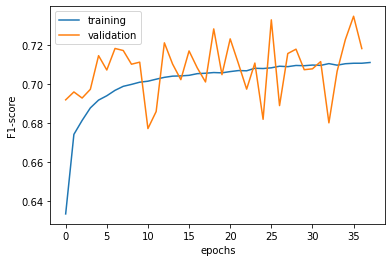

In [2]:
import matplotlib.pyplot as plt

plt.plot(trains)
plt.plot(valids)
plt.legend(['training', 'validation'])
plt.xlabel('epochs')
plt.ylabel('F1-score')

In [11]:
len(positive_trains)

211791

80000

In [3]:
import torch
import torch.nn.functional as F
import torch_geometric
from fcn_policy import FCNNodeDataset, FCNBranchingPolicy, FCNNodeSelectionPolicy
from tqdm import tqdm
from pathlib import Path
import torch.nn as nn
import matplotlib.pyplot as plt
import random
import math 
from torch.utils.data import DataLoader
import numpy as np

from  acr_bb import Observation, ACRBBenv, DefaultBranchingPolicy, RandomPolicy, LinearObservation
from fcn_training import FCNDataset, FCNBranchingPolicy, FCNNodeSelectionPolicy 

MAX_SAMPLES = 100000

N = 8 # antennas
M = 4 # users
expert_prob = 0.5

def instance_generator(M, N):
    while 1:
        yield np.random.randn(2,N,M)

# instances = np.random.randn(MAX_SAMPLES, 2, N, M)
instances = instance_generator(M,N)

env = ACRBBenv(observation_function=LinearObservation)

obs, _,_,_,_  = env.reset(next(instances))

obs, _,_,_,_ = env.step(2)


# a = obs.observation[24:28] + 1j*obs.observation[28:32]
# angle = np.angle(a) 
# angle[angle<0] += 2*np.pi
# lb = obs.observation[24+3*8*4+2:126]
# ub = obs.observation[126:130]
# if np.random.rand(1)>0.3:
#     mid = lb + np.random.rand(4)*(ub-lb)
#     r = 1
#     comp = np.exp(1j*mid)
#     print('here')
# else:
#     mid = np.random.rand(4)*2*np.pi
#     r = 1
#     comp = np.exp(1j*mid)
# if sum(mid<ub)+sum(mid>lb) == 8:
#     label = 1
# else:
#     label = 0

# print(mid)
# print(lb)
# print(ub)

In [ ]:
env.H_complex

In [ ]:
obs.observation[24:24+ 32*2]


In [207]:
import torch

torch.cat((torch.tensor(np.real(mid)), torch.tensor(np.imag(mid)), torch.tensor(np.abs(mid)), torch.tensor(obs.observation))).shape

torch.Size([158])

In [4]:
import numpy as np
a = np.random.rand(5,1)

In [5]:
a.squeeze()

array([0.76917677, 0.74182199, 0.45606417, 0.49266163, 0.1881559 ])

In [85]:
a = np.random.rand(4)*2*np.pi
b = np.random.rand(4)*2*np.pi
c = np.random.rand(4)*2*np.pi



In [86]:
sum(c< a)

3

In [76]:
b<c

array([False, False, False,  True])

In [66]:
comp

array([-1.+1.2246468e-16j, -1.+1.2246468e-16j, -1.+1.2246468e-16j,
       -1.+1.2246468e-16j])

In [67]:
lb

array([0., 0., 0., 0.])

In [68]:
ub

array([6.28318531, 6.28318531, 6.28318531, 6.28318531])

In [59]:
a = 3*np.pi/2 + np.pi/4

In [60]:
a

5.497787143782138

In [62]:
b = 1*np.exp(1j*a)

In [64]:
np.angle(b)+2*np.pi

5.497787143782138

In [53]:
np.random.rand(1)> 0.5

array([ True])

In [28]:
angle

array([0.14602925, 3.63327729, 1.08245673, 1.55202076])

array([ 1.90497712+0.28017676j, -2.52041463-1.34981818j,
        1.24287801+2.33950317j,  0.02418395+1.28790262j])

In [16]:
obs

In [14]:
env.observation

AttributeError: 'ACRBBenv' object has no attribute 'observation'

In [12]:
env.

In [ ]:
policy = FCNNodeSelectionPolicy()



In [ ]:
a = torch.randn(())

In [4]:
a, b = train_data[0]

In [5]:
a.shape

torch.Size([146])

In [6]:
b.shape

torch.Size([])

In [21]:
import gzip
import pickle

with gzip.open('fcn_negative_node_samples/sample_10.pkl','rb') as f:
    sample = pickle.load(f)

In [7]:
import numpy as np

np.linalg.norm(np.random.randn(5,1),'fro')**2

3.3041506361597035

In [10]:
2*np.pi + np.angle([1-1j])

array([5.49778714])